In [5]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

import optax

import matplotlib.pyplot as plt

from gpax import ExactGP, SparseGP, GibbsKernel, HomoscedasticNoise, HeteroscedasticNoise
from gpax.utils import constrain, unconstrain, randomize, train_fn
from gpax.plotting import plot_posterior

import tensorflow_probability.substrates.jax as tfp
tfb = tfp.bijectors

from stheno import GP, EQ

import lab.jax as B
from matrix import Dense, dense

import regdata as rd

import pprint
pp = pprint.PrettyPrinter(depth=4)

from jax.config import config
config.update("jax_debug_nans", True)

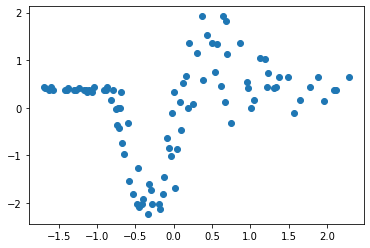

In [6]:
# X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
# # X = jnp.concatenate([X[:40], X[60:]])
# key = jax.random.PRNGKey(0)
# y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2

X, y, X_test = rd.MotorcycleHelmet().get_data()

plt.scatter(X, y);

## Exact GP

In [7]:
X_inducing = X[::10]

kernel = GibbsKernel(X_inducing=X_inducing)
noise = HeteroscedasticNoise(use_kernel_inducing=True)
model = ExactGP(kernel=kernel, noise=noise)
def loss_fun(params):
    return -model.log_probability(params, X, y)

In [8]:
key = jax.random.PRNGKey(0)
params = model.initialise_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(1)
params = randomize(params, key)
jax.value_and_grad(loss_fun)(params)

Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in cholesky

In [10]:
key = jax.random.PRNGKey(0)
params = model.initialise_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(1)
params = randomize(params, key)

# print(ravel_pytree(constrain(params, bijectors)))

optimizer = optax.adam(1e-2)
num_epochs = 100
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

FloatingPointError: invalid value (nan) encountered in scan

In [8]:
result["loss_history"]

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan], dtype=float64)

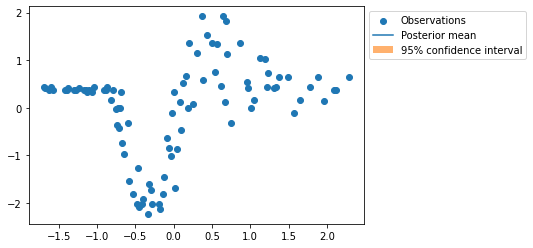

In [7]:
params = constrain(result["params"], bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6);
# k = model.kernel(params['kernel'])
# plt.vlines(params['kernel']['X_inducing'], *plt.ylim(), label='inducing locations', color='red')
ax.legend(bbox_to_anchor=(1,1));

## Sparse GP

In [ ]:
model = SparseGP(
    X_inducing=X[::10],
    kernel=GibbsKernel(X_inducing=X[::11], input_dim=X.shape[1]),
    X=X,
    noise=HomoscedasticNoise(),
    mean=ConstantMean(),
    method="vfe", # "vfe" or "fitc" or "dtc"
)

def loss_fun(params):
    return -model.elbo(params, y)


key = jax.random.PRNGKey(123)
params = model._initialise_params(key)
bijectors = model._get_bijectors()

optimizer = optax.adam(1e-2)
num_epochs = 100

params = unconstrain(params, bijectors)
params = randomize(params, key)
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

In [ ]:
params = constrain(result["params"], bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6)
f = model.get_gp(params)
pseudo_obs = model.get_pseudo_obs(params, f, X, y)
ax.plot(params['X_inducing'], B.dense(pseudo_obs.mu(f.measure)), 'o', color='red', label='pseudo obs');
ax.legend(bbox_to_anchor=(1,1));